# Map Analysis II

###  Renée Hložek and Jeff McMahon

## Using our tools on real data

In this self study exercise, we are now going to use some public data from the ACT collaboration, compute power spectra and compare them to theory power spectra.

In [32]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits
# %cd /Users/reneehlozek/Dropbox/ACTSummerSchool/
# %matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = cs.atmospheric_noise_level
one_over_f_noise_level = cs.one_over_f_noise_level

# Reading in data and making simulated maps
Let's start by reading in a map and computing the power spectrum of the map, and then comparing to a theory map of a similar size/shape

0.49491833030853 0.49407681818181814
map mean: -3.5245380283448906 map rms: 311.228361194383


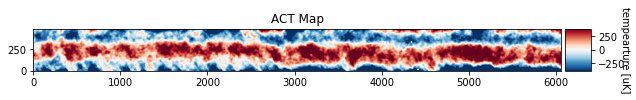

In [33]:
map = fits.getdata('ACT_Season3_148_GHz_submap.fits')
header = fits.getheader('ACT_Season3_148_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins
plt.figure(figsize=(10,10))
p = Plot_CMB_Map(map,c_min,c_max,Nx,Ny, "ACT Map")


You can see that these ACT maps are long stripes, so we will cut a square patch out of the long strip and compute the PS on that patch.

In [49]:
N=int(Ny) # take only one dimension
map_patch = map[0:int(N), 0:int(N)] #trimming the map down to size
# Get two more map patches from a different part of the act map
map_patch2 = map[0:int(N), int(N):2*int(N)]
map_patch3 = map[0:int(N), 2*int(N):3*int(N)]
map_patches = [map_patch, map_patch2, map_patch3]

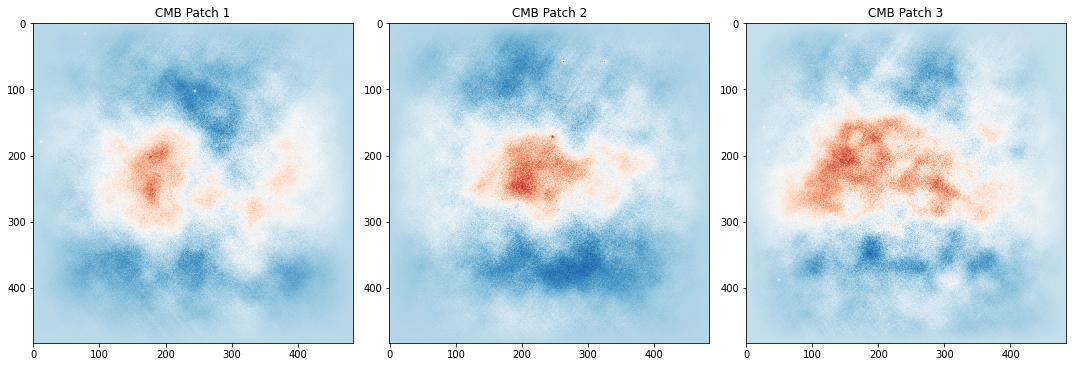

In [73]:
# Making a window function, taking the shorter dimension for now
window = (cosine_window(N))
apodized_maps = []
for i in range(len(map_patches)):
    apodized_map = window * map_patches[i]
    # p=Plot_CMB_Map(apodized_map,c_min,c_max,N, N, "Small Patch Map")
    apodized_maps.append(apodized_map)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(apodized_maps[0], cmap=cm.RdBu_r)
axs[0].set_title('CMB Patch 1')

axs[1].imshow(apodized_maps[1], cmap=cm.RdBu_r)
axs[1].set_title('CMB Patch 2')

axs[2].imshow(apodized_maps[2], cmap=cm.RdBu_r)
axs[2].set_title('CMB Patch 3')

plt.tight_layout()
plt.show()

### We can see that there is a lot of power on large scales from the atmosphere. What do we expect to see in the power spectrum?

Number of sources required:  5000
map mean: -12.200491770070775 map rms: 47.19131624667034


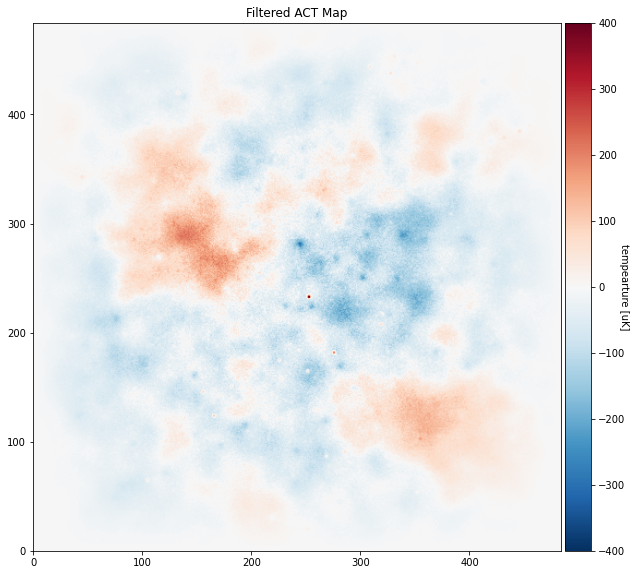

In [52]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 

CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorperate the impact of the instrument
    ## beam
CMB_T_convolved =convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

## plot the result
#p=Plot_CMB_Map(total_map_plus_noise,c_min,c_max,N,N)

appodized_theory_map = window * total_map_plus_noise

p=Plot_CMB_Map(appodized_theory_map,c_min,c_max,N, N, "Filtered ACT Map")

map mean: 6.875028138977774 map rms: 82.63801971988973


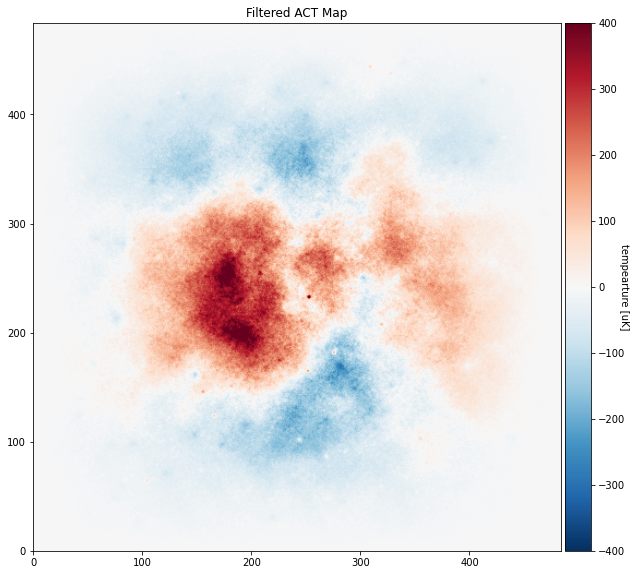

map mean: 6.1003267618717745 map rms: 91.29960662121614


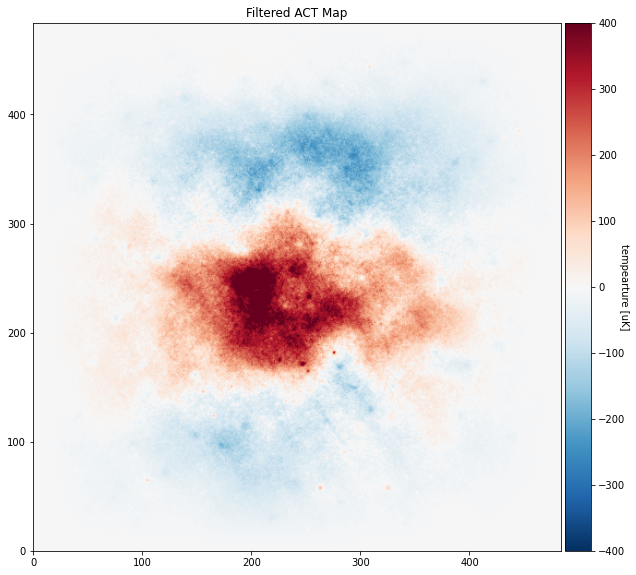

map mean: 10.777502360360202 map rms: 64.40072892951653


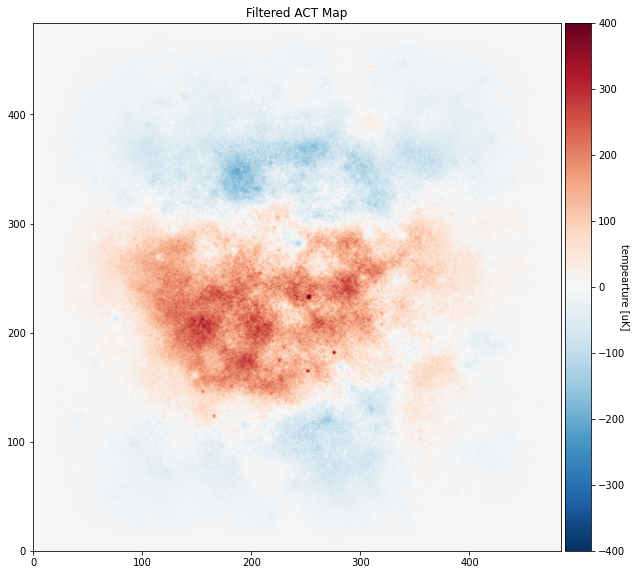

In [75]:
# Do the same for the other map patches
for i in range(len(apodized_maps)):
    total_map = apodized_maps[i] + PSMap + SZMap
    CMB_T_convolved =convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    total_map_plus_noise = CMB_T_convolved + Noise
    appodized_theory_map = window * total_map_plus_noise
    p=Plot_CMB_Map(appodized_theory_map,c_min,c_max,N, N, "Filtered ACT Map")

## We will now take the power spectrum of this apodised map, and the theory version

c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


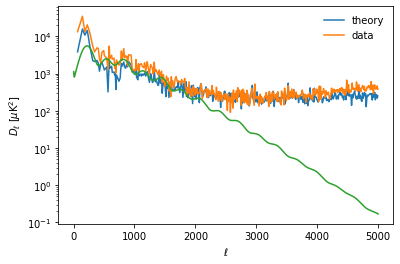

In [56]:
#### parameters for setting up the spectrum
delta_ell = 10# cs.delta_ell
ell_max = cs.ell_max
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')
        
binned_ell_theory, binned_spectrum_theory = \
    calculate_2d_spectrum(appodized_theory_map,delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    calculate_2d_spectrum(appodized_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='theory')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='data')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
# plt.title("Power Spectrum Generated from Data vs Theoretical Power Spectrum")
plt.show()

c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


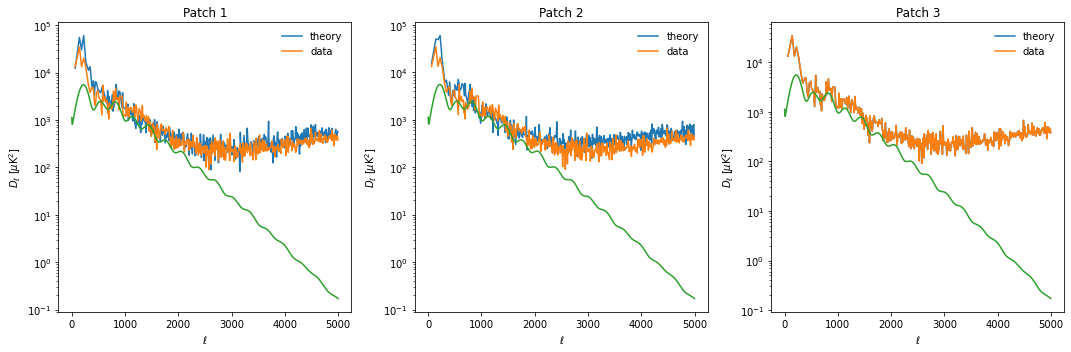

In [64]:
# Combine 3 graphs side-by-side
plt.figure(figsize=(15,5))
plt.subplot(131)
binned_ell_theory, binned_spectrum_theory = \
    calculate_2d_spectrum(apodized_maps[0],delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    calculate_2d_spectrum(apodized_map,delta_ell,ell_max,pix_size,N)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='theory')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='data')
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title("Patch 1")

plt.subplot(132)
binned_ell_theory, binned_spectrum_theory = \
    calculate_2d_spectrum(apodized_maps[1],delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    calculate_2d_spectrum(apodized_map,delta_ell,ell_max,pix_size,N)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='theory')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='data')
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title("Patch 2")

plt.subplot(133)
binned_ell_theory, binned_spectrum_theory = \
    calculate_2d_spectrum(apodized_maps[2],delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    calculate_2d_spectrum(apodized_map,delta_ell,ell_max,pix_size,N)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='theory')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='data')
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title("Patch 3")

plt.tight_layout()
plt.show()


Notice that the power spectrum is biased high on large scales - as we expected it to be.
How might you remove that large scale power before computing the power spectrum?
<font color='red'>EXCERCISE: </font>  Write code to filter out the large scale modes ell < ell_min before computing the power spectrum and show the spectra for a few different values for ell_min. Also, can you think about how to remove the ringing the power on small scales? Discuss the shape of the apodising window and the large scale power leaking to small scales.

In [7]:
## Your code and plots here

<font color='red'>EXCERCISE: </font>  We cut out a particular patch from the ACT strip. Cut out different patches and view them. By using the power spectrum code in the modules file, compute both the auto and the cross spectra for this map. Discuss how you would estimate the error bars on this power spectrum, by comparing the auto with the cross power spectra.

In [8]:
# Your code here

<font color='red'>EXCERCISE: </font>  Given the value of the PS shown here on small scales, we can estimate the noise level in the ACT maps for this season. Plot noise curves for a few values and show here, and do a simple "chi-by-eye" fit for the noise level.

In [9]:
# Your code here

Your discussion here

<font color='red'>EXCERCISE: </font>  Plot the 2D power spectrum, both of your input theory+ noise and the ACT data. What does that tell you about real-world noise from CMB Experiments?

In [10]:
## Your code here

## Frequency dependence of maps and foregrounds

Now we are going to look at ACT maps on the same patch of the sky, but in a different frequency band.

0.49491833030853 0.49407681818181814
map mean: -35.148097186618045 map rms: 319.0813587167169


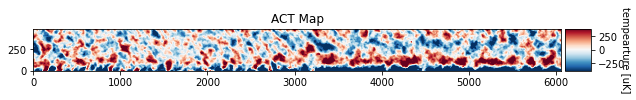

In [11]:
map220 = fits.getdata('ACT_Season3_220_GHz_submap.fits')
header = fits.getheader('ACT_Season3_220_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins
plt.figure(figsize=(10,10))
p = Plot_CMB_Map(map220,c_min,c_max,Nx,Ny, "ACT Map")


c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


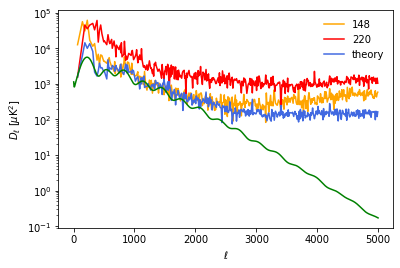

In [26]:
N=int(Ny) # take only one dimension
map_patch220 = map220[0:int(N), 0:int(N)] #trimming the map down to size
window = (cosine_window(N))
appodized_map220 = window * map_patch220

binned_ell_dat220, binned_spectrum_dat220 = calculate_2d_spectrum(appodized_map220,delta_ell,ell_max,pix_size,N)
plt.semilogy(binned_ell_dat,binned_spectrum_dat* binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='148', color="orange")
plt.semilogy(binned_ell_dat220,binned_spectrum_dat220* binned_ell_dat220 * (binned_ell_dat220+1.)/2. / np.pi, label='220', color="red")
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='theory', color="royalblue")
#plt.clf()
leg = plt.legend()

leg.draw_frame(False)
plt.semilogy(ell,DlTT, color="green")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

<font color='red'>EXCERCISE: </font> The spectrum is biased high from point sources on all scales. Use the code from the previous notebook to determine the noise bias for this spectrum and remove it.

In [ ]:
## Your code here

<font color='red'>EXCERCISE: </font> Apply the techniques from Part Five and search for point sources and SZ clusters in the map